In [10]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.signal as sig
import pickle
import os.path

import sys
sys.path.append('..')
from systemprbm import UnitCell, System
import prbm_helper_functions as phf

import scipy.interpolate as interp
from ECA_plotting import *
from ElementaryCA import *
from matplotlib.animation import FuncAnimation

params = phf.define_params()
rule_dict = separable_rules()

# params["tog_offset"]=1.4e-3


In [11]:
config = [0]
system = System(config,params)
d6range = np.linspace(28.7e-3,60e-3,20)
slopes = []
for d6 in d6range:
    slopes.append(system.get_threshold_stiffnesses(d6max=d6))
slopes = np.array(slopes)
slopes = slopes[:,:,2]
stiffness_ratio = slopes[:,1]/slopes[:,0]
slope1_spline = interp.UnivariateSpline(d6range, -slopes[:,0], s=0)
slope2_spline = interp.UnivariateSpline(d6range, -slopes[:,1], s=0)
stiffness_ratio_spline_inverse = interp.UnivariateSpline(stiffness_ratio[::-1], d6range[::-1], s=0)

In [44]:
n = 10
rulenum = 110
rule = rule_dict[rulenum]
d6 = stiffness_ratio_spline_inverse(rule[1][1]/rule[1][0])
k_critical = slope1_spline(d6)
k_critical2 = slope2_spline(d6)
stiffnesses = rule[0]*k_critical/rule[1][0]
params['K1'],params['K2'],params['K3'] = stiffnesses
config = [0]*n
config[-1] = 1
system = System(config,params)

results, y, t = system.simulate_actuation(n_cycles=n)

C:\Users\eoinl\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Text(0, 0.5, 'Clock cycle')

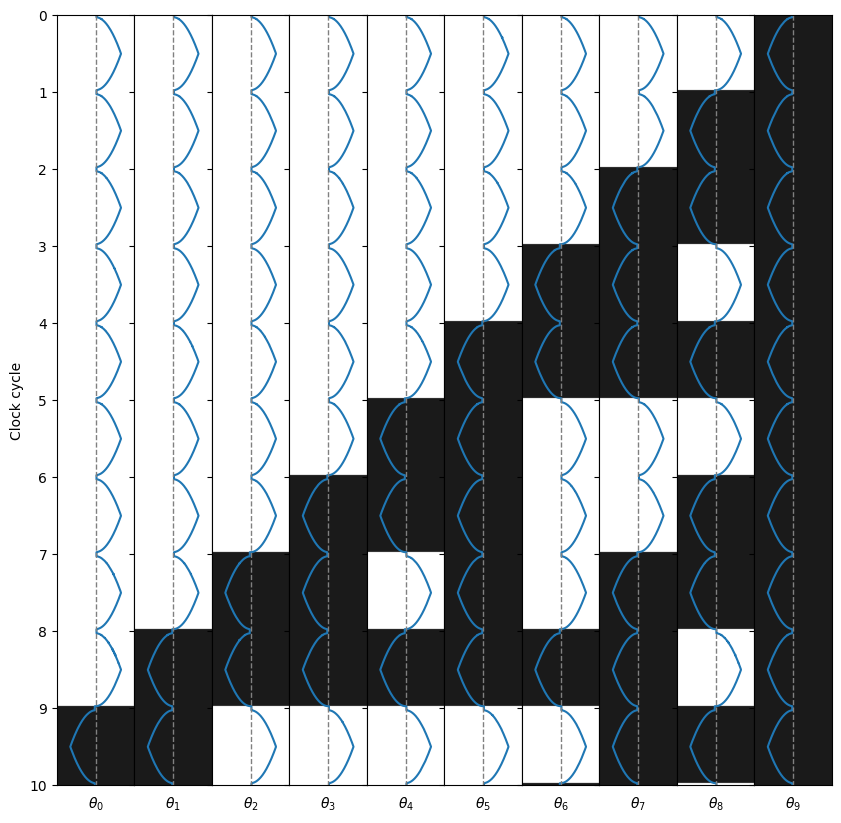

In [57]:



fig, axes = plt.subplots(1,len(config),figsize=(n,n), sharey=True)
plt.subplots_adjust(wspace=0)
for i,ax in enumerate(axes):
    image_data = np.ones((results.shape[0], 1))

    # color entries of the image according to the value of the corresponding pixel in the results array, 0 if the value is negative and 1 if it is positive
    image_data[results[:,2*i+1]<0] = 0

    ax.invert_yaxis()
    ax.imshow(image_data, aspect='auto', extent=[xlim:= -0.8, -xlim, t[-1], t[0]], cmap='gray',alpha=0.9)
    ax.plot(results[:,2*i+1],t)
    ax.set_xlim([xlim,-xlim])
    ax.vlines(0,color='grey',ymin=t[0],ymax=t[-1],linestyle='dashed',lw=1)
    ax.set_xlabel(r'$\theta_{}$'.format(i))
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n+1))
    # ax.grid()

axes[0].set_ylabel('Clock cycle')



(10.0, 0.0)

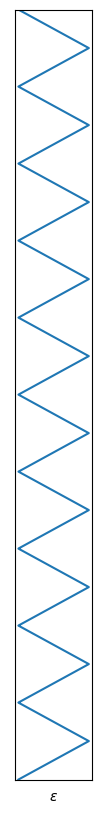

In [84]:
fig, axes = plt.subplots(1,1,figsize=(1,n))
plt.subplots_adjust(wspace=0)
d6max = 33e-3
umax = 2*(system.params['L4']-np.sqrt(system.params['L4']**2-d6max**2))
u_range = (sig.sawtooth(2*np.pi*t, width=0.5)+1)/2*(umax-system.u_init)+system.u_init
axes.plot(u_range,t)
axes.invert_yaxis()
axes.set_xlabel(r'$\varepsilon$')
axes.set_xticks([])
axes.set_yticks([])
axes.set_ylim([t[-1],t[0]])


Text(0, 0.5, 'Clock cycle')

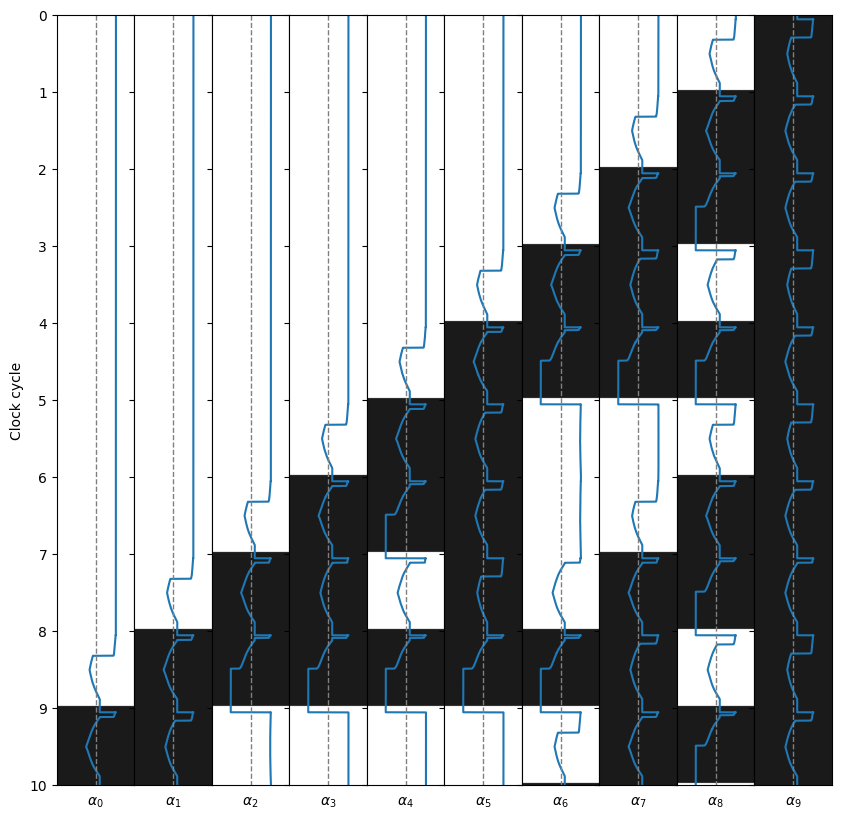

In [59]:
fig, axes = plt.subplots(1,len(config),figsize=(n,n), sharey=True)
plt.subplots_adjust(wspace=0)
for i,ax in enumerate(axes):
    image_data = np.ones((results.shape[0], 1))

    # color entries of the image according to the value of the corresponding pixel in the results array, 0 if the value is negative and 1 if it is positive
    image_data[results[:,2*i+1]<0] = 0

    ax.invert_yaxis()
    ax.imshow(image_data, aspect='auto', extent=[xlim:= -0.8, -xlim, t[-1], t[0]], cmap='gray',alpha=0.9)
    ax.plot(results[:,2*i],t)
    ax.set_xlim([xlim,-xlim])
    ax.vlines(0,color='grey',ymin=t[0],ymax=t[-1],linestyle='dashed',lw=1)
    ax.set_xlabel(r'$\alpha_{}$'.format(i))
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n+1))
    # ax.grid()

axes[0].set_ylabel('Clock cycle')

Text(0, 0.5, 'Clock cycle')

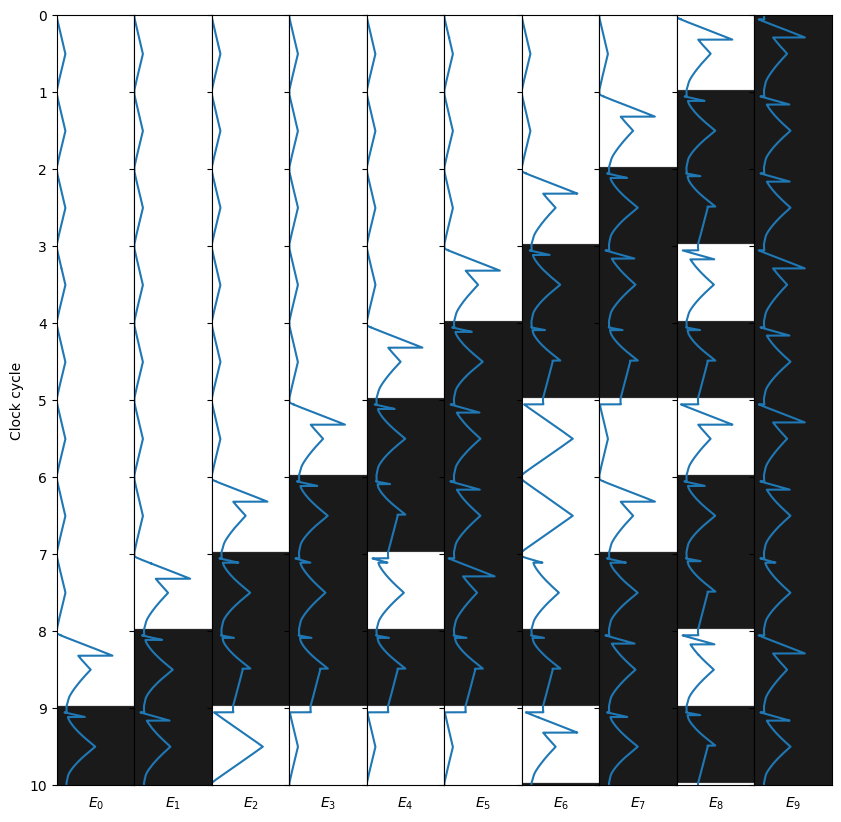

In [73]:
fig, axes = plt.subplots(1,len(config),figsize=(n,n), sharey=True)
plt.subplots_adjust(wspace=0)
for i,ax in enumerate(axes):
    image_data = np.ones((results.shape[0], 1))

    # color entries of the image according to the value of the corresponding pixel in the results array, 0 if the value is negative and 1 if it is positive
    image_data[results[:,2*i+1]<0] = 0

    ax.invert_yaxis()
    ax.imshow(image_data, aspect='auto', extent=[xlim_l:= 0, xlim_u:=0.1, t[-1], t[0]], cmap='gray',alpha=0.9)
    ax.plot(y['E'][i],t)
    ax.set_xlim([xlim_l,xlim_u])
    ax.set_xlabel(r'$E_{}$'.format(i))
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,n+1))
    # ax.grid()

axes[0].set_ylabel('Clock cycle')

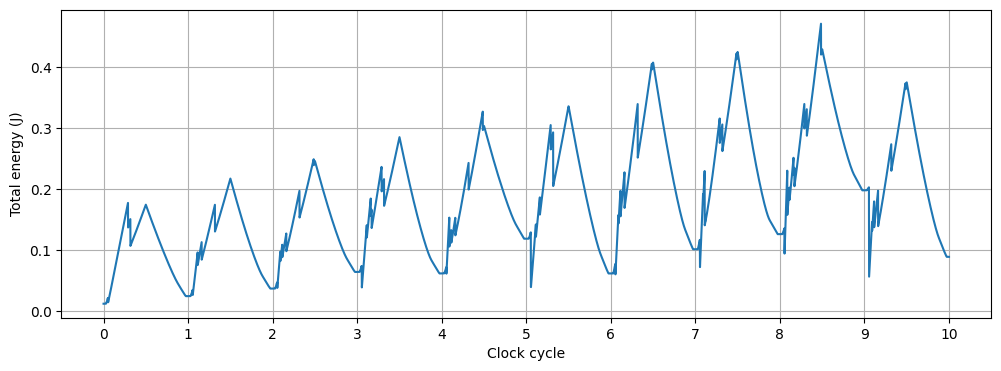

In [72]:
fig = plt.figure(figsize=(12,4))
ax = plt.axes()
ax.plot(t,y['E'].sum(axis=0))
ax.set_xlabel('Clock cycle')
ax.set_ylabel('Total energy (J)')
ax.set_xticks(np.arange(0,n+1))
ax.grid()
